# Nature Recorder Heatmap

This notebook generates and exports a heatmap of species sightings for a category for a given location and year. To use it, update the year, location, category and required export format in the first code cell, below, before running the notebook.

In [ ]:
# Year to report on
year = ""

# Name of the location to report on
location = ""

# Species category to report on
category = ""

# Export format - either PNG or PDF
export_format = "PNG"

In [27]:
from pathlib import Path

# Read the query file
query_file_path = Path("sql") / "sightings.sql"
with open(query_file_path.absolute(), "r") as f:
    query = f.read().replace("\n", " ")

# Replace the location and year placeholders
query = query.replace("$YEAR", year) \
             .replace("$LOCATION", location) \
             .replace("$CATEGORY", category) \
             .replace("$SPECIES", "")

In [28]:
import pandas as pd
import sqlite3
import os

# Connect to the database, execute the query and read the results into a dataframe
database_path = os.environ["NATURE_RECORDER_DB"]
connection = sqlite3.connect(database_path)
df = pd.read_sql_query(query, connection, parse_dates=["Date"])

In [29]:
import calendar

# Pre-process the data to provide a heatmap data source
df["Month"] = df["Date"].dt.month
heatmap_data = df.groupby(["Species", "Month"]).size().unstack(fill_value=0)
heatmap_data.columns = [calendar.month_abbr[m] for m in heatmap_data.columns]

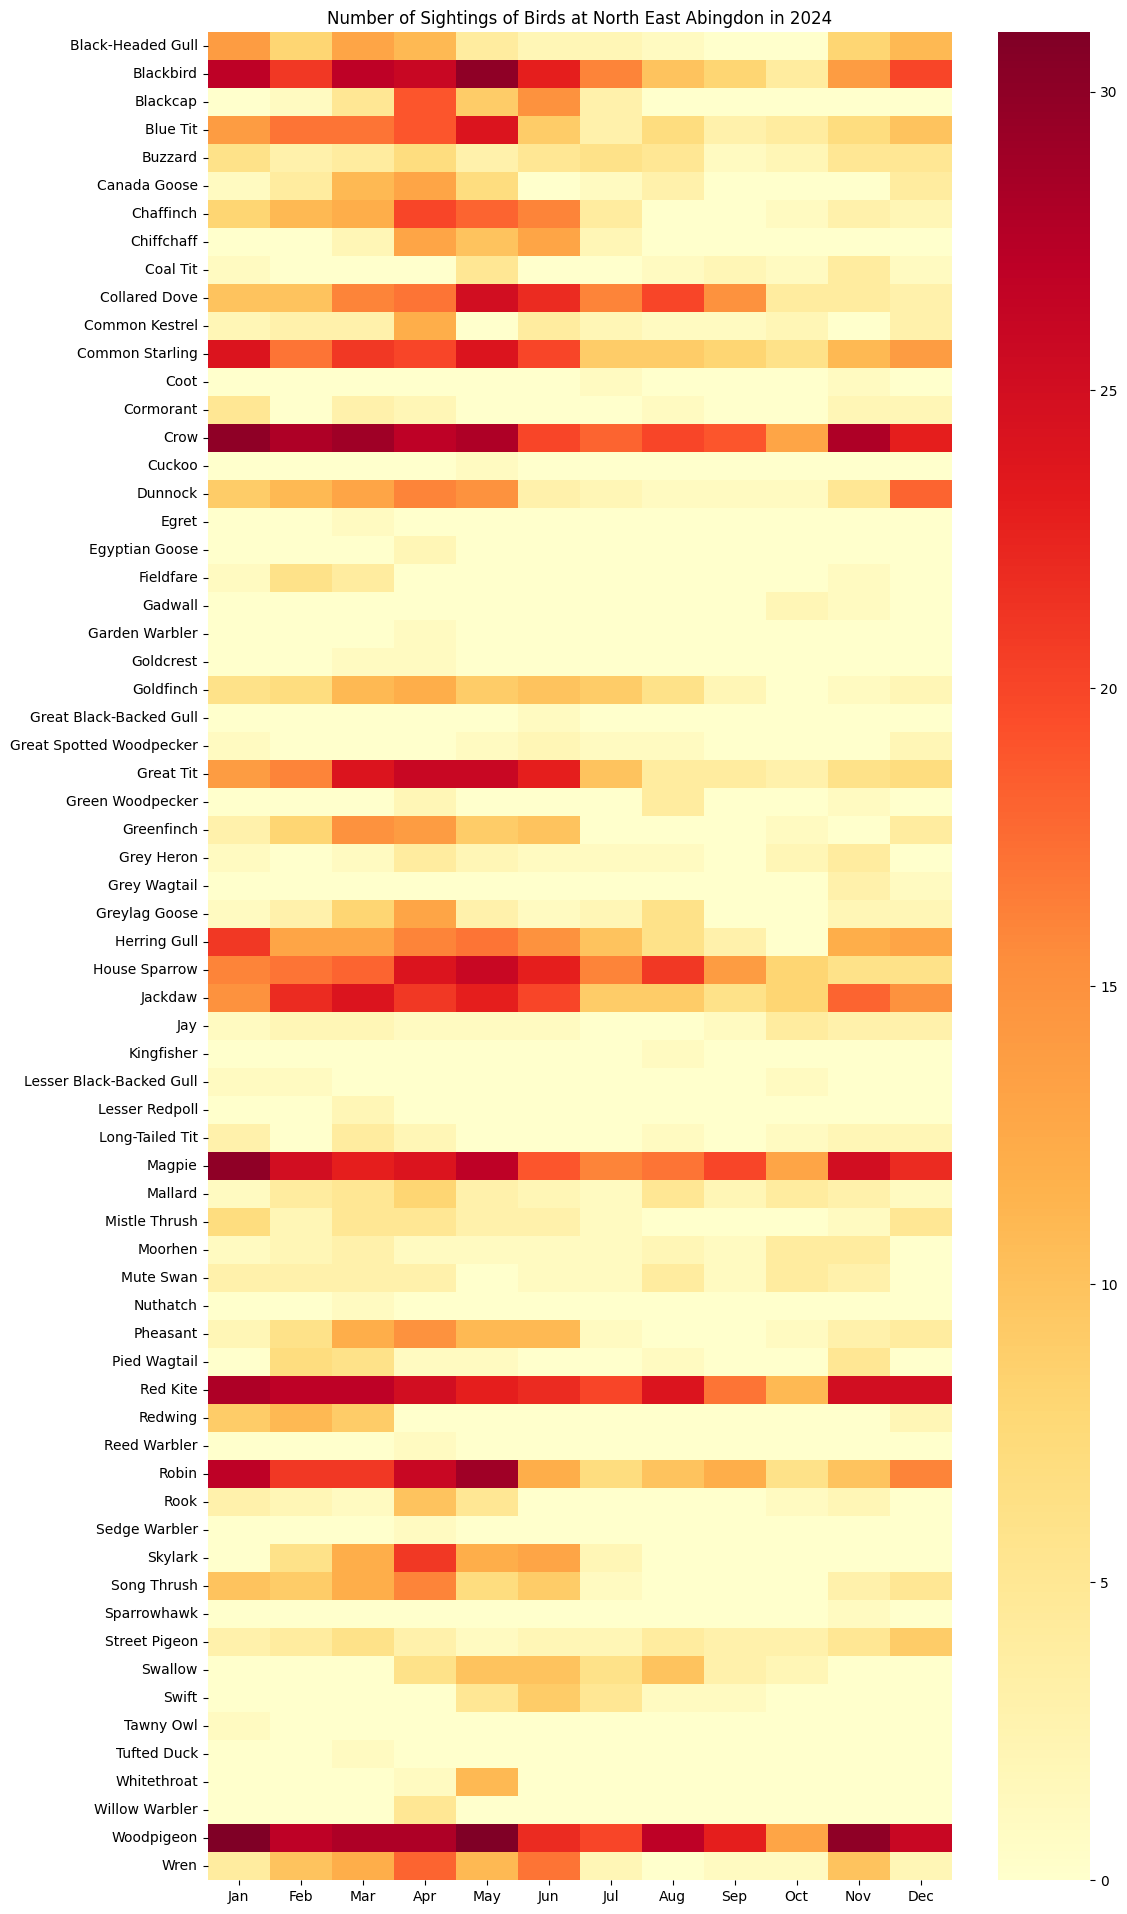

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the heatmap
plt.figure(figsize=(12, 24))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=False)
plt.title(f"Number of Sightings of {category} at {location} in {year}")
plt.xlabel("")
plt.ylabel("")

# Create the folder to hold exported reports
export_folder_path = Path("exported")
export_folder_path.mkdir(parents=True, exist_ok=True)

# Export to PNG
if export_format.casefold() == "png":
    export_file_path = export_folder_path / f"{year}-{category}-Heatmap.png"
    plt.savefig(export_file_path.absolute(), format="png", dpi=300, bbox_inches="tight")

# Export to PDF
if export_format.casefold() == "pdf":
    export_file_path = Path("exported") / f"{year}-{category}-Heatmap.pdf"
    plt.savefig(export_file_path.absolute(), format="pdf", bbox_inches="tight")

# And show the plot
plt.show()